In [1]:
import pandas as pd
import numpy as np
from tkinter import Tk
import os
import datetime
import xlsxwriter

In [2]:
opp = 1401

In [3]:
def read_excelfiles(extension):
    # Ask for directory
    # from tkinter.filedialog import askdirectory
    # path_files = askdirectory(title='Selecteer de map met alle ruwe input') # shows dialog box and return the path
    file_path = r"C:\Users\hnx\Desktop\Weesp"
    list_files = []

    for filename in os.listdir(file_path):
        if filename.endswith(extension):
            list_files.append(os.path.join(file_path, filename))
        else:
            continue

    return list_files

In [4]:
# Converteer excel naar csv, dat leest veel sneller in.
convert = False

if convert:
    list_files_xlsx = read_excelfiles(extension='xlsx')
    for el in list_files_xlsx:
        print(el)
        df_i = pd.read_excel(el)
        pre, ext = os.path.splitext(el)
        new_name = pre + ".csv"
        print(new_name)
        df_i.to_csv(new_name, index=False)

Lees data en maak onderscheid twee methodes


In [5]:
list_files = read_excelfiles(extension='csv')

In [6]:
# read csv files
dfs = [pd.read_csv(el, sep=',',index_col=[0], parse_dates=[0], decimal='.') for el in list_files]

df = pd.concat(dfs).sort_index()
df = df.max(level=0)

# Calculate flows
# df["Influentdebiet"] = np.where(df['7019 BC_A130_O'] == 1, df["7003 RGI_FTxyz_PW"]/2, df["7003 RGI_FTxyz_PW"])
df["Influentdebiet"] = df["7003 RGI_FTxyz_PW"]/2
df["Opstroomsnelheid"] = df["Influentdebiet"]/opp

# Onderscheid data in 2 methodes: compleet gebruik luchtkleppen 7019 BC_A130_D, incompleet gebruik waterhoogte 7009 AT_LT114_AM
df_compleet = df[df["7019 BC_A130_D"].notnull()]
df_incompleet1 = df[(df["7019 BC_A130_D"].isnull()) & (df["7009 AT_LT114_AM"].notnull())]
df_incompleet2 = df[(df["7019 BC_A151_D"].isnull()) & (df["7010 AT_LT114_AM"].notnull())]


Methode 1: met waterhoogte

In [7]:
# Vindt alle cyclussen: hun totale duur en begin- en eindtijd.
# AT 1

m_i = 0
begin_cyclus1 = []

# Incompleet
while m_i < len(df_incompleet1.index):
    m = df_incompleet1.index[m_i]

    i_m108 = m - datetime.timedelta(minutes=108)
    i_p108 = m + datetime.timedelta(minutes=108)

    if (df_incompleet1.loc[m, "7009 AT_LT114_AM"] == df_incompleet1.loc[i_m108:i_p108, "7009 AT_LT114_AM"].min()):
        i_m1 = m - datetime.timedelta(minutes=1)
        i_p1 = m + datetime.timedelta(minutes=1)
        
        if (df_incompleet1.loc[m, "7009 AT_LT114_AM"] <= df_incompleet1.loc[i_m1, "7009 AT_LT114_AM"]) and\
            (df_incompleet1.loc[m, "7009 AT_LT114_AM"] <= df_incompleet1.loc[i_p1, "7009 AT_LT114_AM"]):
            begin_cyclus1.append([m,1,np.nan,np.nan,np.nan,np.nan,np.nan])
            m_i += 50
        
        else:
            m_i += 1
       
    else:
        m_i += 1

In [8]:
# Vindt alle cyclussen: hun totale duur en begin- en eindtijd.
# AT2
m_i = 0
begin_cyclus2 = []

# Incompleet
while m_i < len(df_incompleet2.index):
    m = df_incompleet2.index[m_i]    

    i_m108 = m - datetime.timedelta(minutes=108)
    i_p108 = m + datetime.timedelta(minutes=108)

    try:
        if df_incompleet2.loc[m, "7010 AT_LT114_AM"] == df_incompleet2.loc[i_m108:i_p108, "7010 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df_incompleet2.loc[m, "7010 AT_LT114_AM"] <= df_incompleet2.loc[i_m1, "7010 AT_LT114_AM"]) and\
                (df_incompleet2.loc[m, "7010 AT_LT114_AM"] <= df_incompleet2.loc[i_p1, "7010 AT_LT114_AM"]):
                begin_cyclus2.append([m,1,np.nan,np.nan,np.nan,np.nan,np.nan])
                m_i += 50
            
            else:
                m_i += 1

        else:
            m_i += 1

    except:

        m_i += 1

In [9]:
# Bepaal gemiddelde opstroomsnelheid, begin bezinktijd en bezinkduur, slibgehalte, waterhoogte
# AT 1
results_1a = []

for a in range(len(begin_cyclus1)-1):
    duur = begin_cyclus1[a+1][0] - begin_cyclus1[a][0]
    begin_cyclus1[a][2] = duur
   
    if datetime.timedelta(minutes=270) < duur < datetime.timedelta(minutes=292):
        start_date = begin_cyclus1[a][0] + datetime.timedelta(minutes=168)

    elif datetime.timedelta(minutes=200) < duur < datetime.timedelta(minutes=230):
        start_date = begin_cyclus1[a][0] + datetime.timedelta(minutes=126)

    else:
        continue

    end = False

    j = start_date
    max_date = j+datetime.timedelta(minutes=170)

    while not end:
        j = j + datetime.timedelta(minutes=1)
        try:
            if j > max_date:
                end = True

            elif df_incompleet1.loc[j, "7009 AT_QT112_AM"] < 1.0:
                j_p10 = j+datetime.timedelta(minutes=20)
                selection = df_incompleet1.loc[j:j_p10, "7009 AT_QT112_AM"]
                minimum = selection.min()

                if minimum < 0.1:
                    small_selection = selection.where(selection<0.1)
                    end_date = small_selection.first_valid_index()
                else:
                    end_date = df_incompleet1.loc[j:j_p10, "7009 AT_QT112_AM"].idxmin()

                end = True

        except:
            continue
    
    try:
        average = np.mean(df_incompleet1.loc[start_date:end_date, "Opstroomsnelheid"])
        duration = end_date-start_date
        hours = duration.total_seconds()/3600
        results_1a.append([start_date, begin_cyclus1[a][0], duur, df_incompleet1.loc[start_date, "7009 AT_QT112_AM"],\
            df_incompleet1.loc[start_date, "7009 AT_LT114_AM"], average, hours])
    except:
        continue

df_temp1 = pd.DataFrame(results_1a, columns=["sTime", "Begin_cyclus1", "Cyclusduur1", "Slibgehalte1", "Waterhoogte1", "Opstroomsnelheid1", "Duur1"])
df_temp1 = df_temp1[df_temp1["Duur1"]>0]
df_temp1 = df_temp1.set_index(keys="sTime", drop=True)


In [10]:
# Bepaal gemiddelde opstroomsnelheid, begin bezinktijd en bezinkduur, slibgehalte, waterhoogte
# AT 2
results_2a = []
for a in range(len(begin_cyclus2)-1):
    duur = begin_cyclus2[a+1][0] - begin_cyclus2[a][0]
    begin_cyclus2[a][2] = duur
   
    if datetime.timedelta(minutes=270) < duur < datetime.timedelta(minutes=292):
        start_date = begin_cyclus2[a][0] + datetime.timedelta(minutes=168)

    elif datetime.timedelta(minutes=200) < duur < datetime.timedelta(minutes=230):
        start_date = begin_cyclus2[a][0] + datetime.timedelta(minutes=126)
    else:
        continue

    end = False

    j = start_date
    max_date = j+datetime.timedelta(minutes=170)

    while not end:
        j = j + datetime.timedelta(minutes=1)
        try:
            if j > max_date:
                end = True

            elif df_incompleet2.loc[j, "7010 AT_QT112_AM"] < 1.0:
                j_p10 = j+datetime.timedelta(minutes=20)
                selection = df_incompleet2.loc[j:j_p10, "7010 AT_QT112_AM"]
                minimum = selection.min()

                if minimum < 0.1:
                    small_selection = selection.where(selection<0.1)
                    end_date = small_selection.first_valid_index()
                else:
                    end_date = df_incompleet2.loc[j:j_p10, "7010 AT_QT112_AM"].idxmin()

                end = True

        except:
            continue
    
    try:
        average = np.mean(df_incompleet2.loc[start_date:end_date, "Opstroomsnelheid"])
        duration = end_date-start_date
        hours = duration.total_seconds()/3600
        results_2a.append([start_date, begin_cyclus2[a][0], duur, df_incompleet2.loc[start_date, "7010 AT_QT112_AM"],\
            df_incompleet2.loc[start_date, "7010 AT_LT114_AM"], average, hours])
    except:
        continue

df_temp2 = pd.DataFrame(results_2a, columns=["sTime", "Begin_cyclus2", "Cyclusduur2", "Slibgehalte2", "Waterhoogte2", "Opstroomsnelheid2", "Duur2"])
df_temp2 = df_temp2[df_temp2["Duur2"]>0]
df_temp2 = df_temp2.set_index(keys="sTime", drop=True)

Methode 2: met luchtkleppen

In [11]:
# Loop and find cycles and average upwards flow in cycle part 2
# AT 1

m_i = 0
begin_cyclus1a = []

# Incompleet
while m_i < len(df_compleet.index):
    m = df_compleet.index[m_i]
    try:
        i_m108 = m - datetime.timedelta(minutes=108)
        i_p108 = m + datetime.timedelta(minutes=108)

        if df_compleet.loc[m, "7009 AT_LT114_AM"] == df_compleet.loc[i_m108:i_p108, "7009 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df_compleet.loc[m, "7009 AT_LT114_AM"] <= df_compleet.loc[i_m1, "7009 AT_LT114_AM"]) and\
                (df_compleet.loc[m, "7009 AT_LT114_AM"] <= df_compleet.loc[i_p1, "7009 AT_LT114_AM"]):
                begin_cyclus1a.append([m])
                m_i += 50
            
            else:
                m_i += 1
        
        else:
            m_i += 1
    except:
        m_i += 1

# Loop and find cycles and average upwards flow in cycle part 2
# AT 2

m_i = 0
begin_cyclus2a = []

# Incompleet
while m_i < len(df_compleet.index):
    m = df_compleet.index[m_i]
    try:
        i_m108 = m - datetime.timedelta(minutes=108)
        i_p108 = m + datetime.timedelta(minutes=108)

        if df_compleet.loc[m, "7010 AT_LT114_AM"] == df_compleet.loc[i_m108:i_p108, "7010 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df_compleet.loc[m, "7010 AT_LT114_AM"] <= df_compleet.loc[i_m1, "7010 AT_LT114_AM"]) and\
                (df_compleet.loc[m, "7010 AT_LT114_AM"] <= df_compleet.loc[i_p1, "7010 AT_LT114_AM"]):
                begin_cyclus2a.append([m])
                m_i += 50
            
            else:
                m_i += 50
        
        else:
            m_i += 1
       
    except:
        m_i += 1

In [12]:
# Vindt cyclusduur
for a in range(len(begin_cyclus1a)-1):
    duur = begin_cyclus1a[a+1][0] - begin_cyclus1a[a][0]
    begin_cyclus1a[a].append(duur)

for a in range(len(begin_cyclus2a)-1):
    duur = begin_cyclus2a[a+1][0] - begin_cyclus2a[a][0]
    begin_cyclus2a[a].append(duur)
   

In [13]:
# Maak dataframes van cyclusdata compleet
df_temp1a = pd.DataFrame(begin_cyclus1a, columns=["Begin_cyclus1", "Cyclusduur1"])
df_temp1a = df_temp1a.set_index(keys="Begin_cyclus1", drop=True)
print(df_temp1a.head())

df_temp2a = pd.DataFrame(begin_cyclus2a, columns=["Begin_cyclus2", "Cyclusduur2"])
df_temp2a = df_temp2a.set_index(keys="Begin_cyclus2", drop=True)
print(df_temp2a.head())

                        Cyclusduur1
Begin_cyclus1                      
2020-05-01 06:40:00 0 days 04:48:00
2020-05-01 11:28:00 0 days 04:49:00
2020-05-01 16:17:00 0 days 04:47:00
2020-05-01 21:04:00 0 days 04:49:00
2020-05-02 01:53:00 0 days 04:48:00
                        Cyclusduur2
Begin_cyclus2                      
2020-05-01 04:17:00 0 days 04:48:00
2020-05-01 09:05:00 0 days 04:48:00
2020-05-01 13:53:00 0 days 04:48:00
2020-05-01 18:41:00 0 days 04:49:00
2020-05-01 23:30:00 0 days 04:48:00


In [14]:
results_at1 = []
results_at2 = []

for i in df_compleet.index[1:]:
    i_1 = i - datetime.timedelta(minutes=1)

    try:
        if df_compleet.loc[i, "7019 BC_A130_D"] > 0 and df_compleet.loc[i_1, "7019 BC_A130_D"] == 0:
            start_date = i_1
            end = False
            j = i
            while not end:
                j += datetime.timedelta(minutes=1)
                try:
                    if df_compleet.loc[j, "7009 AT_QT112_AM"] < 0.1:
                        end_date = j
                        end = True

                    elif j == df_compleet.index[-1]:
                        print("True")
                        end =True
                except:
                    continue
            
            average = np.mean(df_compleet.loc[start_date:end_date, "Opstroomsnelheid"])
            duration = end_date-start_date
            hours = duration.total_seconds()/3600
            
            results_at1.append([start_date, df_compleet.loc[start_date, "7009 AT_QT112_AM"],\
                    df_compleet.loc[start_date,"7009 AT_LT114_AM"], average, hours])     

        # AT 2

        if df_compleet.loc[i, "7019 BC_A151_D"] > 0 and df_compleet.loc[i_1, "7019 BC_A151_D"] == 0:
            start_date = i_1

            end = False
            j = i
            while not end:
                j += datetime.timedelta(minutes=1)
                try:
                    if df_compleet.loc[j, "7010 AT_QT112_AM"] < 0.1:
                        end_date = j
                        end = True

                    elif j == df_compleet.index[-1]:
                        print("True")
                        end =True
                except:
                    continue
            
            average = np.mean(df_compleet.loc[start_date:end_date, "Opstroomsnelheid"])
            duration = end_date-start_date
            hours = duration.total_seconds()/3600
            
            results_at2.append([start_date, df_compleet.loc[start_date, "7010 AT_QT112_AM"],\
                    df_compleet.loc[start_date,"7010 AT_LT114_AM"], average, hours])     
    except:
        continue


In [15]:
df1 = pd.DataFrame(results_at1, columns=["sTime", "Slibgehalte1", "Waterhoogte1", "Opstroomsnelheid1", "Duur1"])
df2 = pd.DataFrame(results_at2, columns=["sTime", "Slibgehalte2", "Waterhoogte2", "Opstroomsnelheid2", "Duur2"])
df1.set_index(keys="sTime", drop=True, inplace = True)
df2.set_index(keys="sTime", drop=True, inplace = True)

In [16]:
# Vind juiste cyclusduur bij df1 en df2 uit df_temp1a en df_temp2a
# AT1
dict_cyclus1 = {}
for el in df1.index:
    try:
        num = df_temp1a.index.get_loc(el, method='ffill')
        diff = el - df_temp1a.index[num]
        compare = pd.Timedelta('0 days 03:20:00')
        if diff < compare:
            dict_cyclus1[el] = (df_temp1a.index[num], df_temp1a.iloc[num]["Cyclusduur1"])
    except:
        print("No previous value")

df1_dict = pd.DataFrame.from_dict(dict_cyclus1, columns=['Begin_cyclus1', 'Cyclusduur1'], orient='index')
df1 = pd.merge(df1, df1_dict, left_index=True, right_index=True, how='left')
print(df1.head())

# AT2
dict_cyclus2 = {}
for el in df2.index:
    try:
        num = df_temp2a.index.get_loc(el, method='ffill')
        diff = el - df_temp2a.index[num]
        compare = pd.Timedelta('0 days 03:20:00')
        if diff < compare:
            dict_cyclus2[el] = (df_temp2a.index[num], df_temp2a.iloc[num]["Cyclusduur2"])
    except:
        print("No previous value")

df2_dict = pd.DataFrame.from_dict(dict_cyclus2, columns=['Begin_cyclus2', 'Cyclusduur2'], orient='index')
df2 = pd.merge(df2, df2_dict, left_index=True, right_index=True, how='left')
print(df2.head())

No previous value
                     Slibgehalte1  Waterhoogte1  Opstroomsnelheid1     Duur1  \
sTime                                                                          
2020-05-01 04:43:00         2.573         5.301           0.210372  0.766667   
2020-05-01 09:32:00         2.797         4.530           0.133554  0.466667   
2020-05-01 14:20:00         2.619         5.280           0.481415  0.816667   
2020-05-01 19:08:00         2.671         5.224           0.265940  0.733333   
2020-05-01 23:56:00         2.926         4.640           0.097458  0.550000   

                          Begin_cyclus1     Cyclusduur1  
sTime                                                    
2020-05-01 04:43:00                 NaT             NaT  
2020-05-01 09:32:00 2020-05-01 06:40:00 0 days 04:48:00  
2020-05-01 14:20:00 2020-05-01 11:28:00 0 days 04:49:00  
2020-05-01 19:08:00 2020-05-01 16:17:00 0 days 04:47:00  
2020-05-01 23:56:00 2020-05-01 21:04:00 0 days 04:49:00  
No previous val

In [101]:
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()
print(df1.head())

                     Slibgehalte1  Waterhoogte1  Opstroomsnelheid1     Duur1  \
sTime                                                                          
2020-05-01 04:43:00         2.573         5.301           0.210372  0.766667   
2020-05-01 09:32:00         2.797         4.530           0.133554  0.466667   
2020-05-01 14:20:00         2.619         5.280           0.481415  0.816667   
2020-05-01 19:08:00         2.671         5.224           0.265940  0.733333   
2020-05-01 23:56:00         2.926         4.640           0.097458  0.550000   

                          Begin_cyclus1     Cyclusduur1  
sTime                                                    
2020-05-01 04:43:00                 NaT             NaT  
2020-05-01 09:32:00 2020-05-01 06:40:00 0 days 04:48:00  
2020-05-01 14:20:00 2020-05-01 11:28:00 0 days 04:49:00  
2020-05-01 19:08:00 2020-05-01 16:17:00 0 days 04:47:00  
2020-05-01 23:56:00 2020-05-01 21:04:00 0 days 04:49:00  


In [117]:
df1_tot = df_temp1.append(df1)
df2_tot = df_temp2.append(df2)


In [118]:
df1_tot["Level sensor1"] = np.where(df1_tot.index<datetime.datetime(2020, 12, 1),3.25,3.86)
df2_tot["Level sensor2"] = np.where(df2_tot.index<datetime.datetime(2020, 12, 1),3.25,3.86)


In [119]:
df1_tot.head()


,Begin_cyclus1,Cyclusduur1,Slibgehalte1,Waterhoogte1,Opstroomsnelheid1,Duur1,Level sensor1
sTime,,,,,,,
2020-03-02 01:58:00,2020-03-01 23:52:00,0 days 03:37:00,3.183,4.710,0.151107,1.133333,3.25
2020-03-02 05:35:00,2020-03-02 03:29:00,0 days 03:36:00,3.351,4.658,0.119904,1.016667,3.25
2020-03-02 09:11:00,2020-03-02 07:05:00,0 days 03:36:00,3.308,4.630,0.178654,1.033333,3.25
2020-03-02 12:47:00,2020-03-02 10:41:00,0 days 03:36:00,3.120,4.895,0.292389,1.550000,3.25
2020-03-02 16:23:00,2020-03-02 14:17:00,0 days 03:36:00,3.194,4.954,0.376766,1.566667,3.25


In [120]:
df1_tot["delta_h1"] = df1_tot["Waterhoogte1"] - df1_tot["Level sensor1"]
df2_tot["delta_h2"] = df2_tot["Waterhoogte2"] - df2_tot["Level sensor2"]

SVI inlezen en toevoegen

In [143]:
svi_loc = r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\SVI.xlsx"
df_SVI = pd.read_excel(svi_loc)
df_SVI.set_index('sTime', drop=True, inplace=True)

df_SVI1 = df_SVI["SVI1"]
df_SVI2 = df_SVI["SVI2"]

df_SVI1 = df_SVI1.dropna()
df_SVI2 = df_SVI2.dropna()

# df_SVI1 = df_SVI1.str.strip().astype(bool)
# df_SVI2 = df_SVI2.str.strip().astype(bool)

svi1_dict = {}
svi2_dict = {}

for elm in df1_tot.index:
    svi1 = df_SVI1.index.get_loc(elm, method='nearest', tolerance=None)
    svi1_dict[elm] = df_SVI1.iloc[svi1]

for elm in df2_tot.index:
    svi2 = df_SVI2.index.get_loc(elm, method='nearest', tolerance=None)
    svi2_dict[elm] = df_SVI2.iloc[svi2]

df1_SVI1 = pd.DataFrame.from_dict(svi1_dict, orient="index", columns=["SVI1"])
df2_SVI2 = pd.DataFrame.from_dict(svi2_dict, orient="index", columns=["SVI2"])

df1S_tot = pd.merge(df1_tot,df1_SVI1, left_index=True, right_index=True)
df2S_tot = pd.merge(df2_tot,df2_SVI2, left_index=True, right_index=True)

In [145]:
df2S_tot.head()

,Begin_cyclus2,Cyclusduur2,Slibgehalte2,Waterhoogte2,Opstroomsnelheid2,Duur2,Level sensor2,delta_h2,SVI2
sTime,,,,,,,,,
2020-03-02 03:46:00,2020-03-02 01:40:00,0 days 03:37:00,3.194,4.690,0.136440,1.116667,3.25,1.440,86.475
2020-03-02 07:23:00,2020-03-02 05:17:00,0 days 03:36:00,3.182,4.630,0.117058,0.933333,3.25,1.380,86.475
2020-03-02 10:59:00,2020-03-02 08:53:00,0 days 03:35:00,3.277,4.716,0.308522,1.116667,3.25,1.466,86.475
2020-03-02 14:34:00,2020-03-02 12:28:00,0 days 03:36:00,3.123,4.920,0.324386,1.583333,3.25,1.670,
2020-03-02 21:46:00,2020-03-02 19:40:00,0 days 03:36:00,3.023,5.091,0.362241,1.583333,3.25,1.841,


In [22]:
df1_tot["Snelheid1"] = df1_tot["delta_h1"]/df1_tot["Duur1"]
df1_tot["Totale snelheid1"] = df1_tot["Snelheid1"] + df1_tot["Opstroomsnelheid1"]
df1_tot["Slibvolume1"] = df1_tot["Slibgehalte1"]*df1_tot["SVI1"]
df2_tot["Snelheid2"] = df2_tot["delta_h2"]/df2_tot["Duur2"]
df2_tot["Totale snelheid2"] = df2_tot["Snelheid2"] + df2_tot["Opstroomsnelheid2"]
df2_tot["Slibvolume2"] = df2_tot["Slibgehalte2"]*df2_tot["SVI2"]

In [23]:
df1_tot[["Level sensor1","Duur1"]]["2020-11-30":"2020-12-01"]

,Level sensor1,Duur1
sTime,,
2020-11-30 02:53:00,3.25,0.483333
2020-11-30 07:40:00,3.25,0.483333
2020-11-30 12:28:00,3.25,0.533333
2020-11-30 17:16:00,3.25,0.500000
2020-11-30 22:05:00,3.25,0.933333
2020-12-01 01:42:00,3.86,0.916667
2020-12-01 05:24:00,3.86,0.750000
2020-12-01 09:37:00,3.86,0.650000
2020-12-01 14:48:00,3.86,0.633333


In [24]:
print(df2_tot)

                          Begin_cyclus2     Cyclusduur2  Slibgehalte2  \
sTime                                                                   
2020-03-02 03:46:00 2020-03-02 01:40:00 0 days 03:37:00         3.194   
2020-03-02 07:23:00 2020-03-02 05:17:00 0 days 03:36:00         3.182   
2020-03-02 10:59:00 2020-03-02 08:53:00 0 days 03:35:00         3.277   
2020-03-02 14:34:00 2020-03-02 12:28:00 0 days 03:36:00         3.123   
2020-03-02 21:46:00 2020-03-02 19:40:00 0 days 03:36:00         3.023   
...                                 ...             ...           ...   
2020-12-06 02:48:00 2020-12-05 23:58:00 0 days 04:48:00         2.725   
2020-12-06 07:36:00 2020-12-06 04:46:00 0 days 04:48:00         2.784   
2020-12-06 12:24:00 2020-12-06 09:34:00 0 days 04:47:00         2.610   
2020-12-06 17:12:00 2020-12-06 14:21:00 0 days 04:48:00         2.653   
2020-12-06 22:01:00 2020-12-06 19:09:00 0 days 04:49:00         2.776   

                     Waterhoogte2  Opstroomsnelhei

In [25]:
# Filter slechte data
# Te laat startslibgehalte
df1_filter = df1_tot[df1_tot["Slibgehalte1"]>2.0]
df2_filter = df2_tot[df2_tot["Slibgehalte2"]>2.0]

# Periode uitval AT1 in juli
start_uitval = datetime.datetime(2020,7,15)
eind_uitval = datetime.datetime(2020,7,30)
df1_filter = df1_filter[(df1_filter.index < start_uitval) | (df1_filter.index > eind_uitval)]

# Duur langer dan cyclusduur-reactietijd

df1_filter["Reactietijd1"] = df1_filter.index-pd.to_datetime(df1_filter["Begin_cyclus1"])
df1_filter = df1_filter[pd.to_timedelta(df1_filter["Duur1"], unit='h')<(df1_filter["Cyclusduur1"]-df1_filter["Reactietijd1"])]

df2_filter["Reactietijd2"] = df2_filter.index-pd.to_datetime(df2_filter["Begin_cyclus2"])
df2_filter = df2_filter[pd.to_timedelta(df2_filter["Duur2"], unit='h')<(df2_filter["Cyclusduur2"]-df2_filter["Reactietijd2"])]

df1_filter = df1_filter[(datetime.timedelta(hours=3)<df1_filter["Cyclusduur1"]) & (df1_filter["Cyclusduur1"]<datetime.timedelta(hours=5))]
df2_filter = df2_filter[(datetime.timedelta(hours=3)<df2_filter["Cyclusduur2"]) & (df2_filter["Cyclusduur2"]<datetime.timedelta(hours=5))]

4 juli is de berekende duur 6 uur, wslijk is slibgehalte niet onder 1 gekomen. Kies of voor verwijderen, of nog hogere grens,
geldt ook over 6 . Alle uitschieters qua snelheid worden door een te korte of te lange duur veroorzaakt. Check of dit altijd door slibgehalte komt iig te hoog, 
en of de te korte nooit een echte cyclus zijn?

In [26]:
df1_filter["Start_bezinken1"] = df1_filter.index
df2_filter["Start_bezinken2"] = df2_filter.index

In [27]:
print(df1_filter["2020-12-6":"2020-12-09"])

                          Begin_cyclus1     Cyclusduur1  Slibgehalte1  \
sTime                                                                   
2020-12-06 00:25:00 2020-12-05 21:33:00 0 days 04:48:00         2.470   
2020-12-06 05:12:00 2020-12-06 02:21:00 0 days 04:48:00         2.607   
2020-12-06 10:00:00 2020-12-06 07:09:00 0 days 04:48:00         2.386   
2020-12-06 14:48:00 2020-12-06 11:57:00 0 days 04:49:00         2.495   
2020-12-06 19:36:00 2020-12-06 16:46:00 0 days 04:47:00         2.550   

                     Waterhoogte1  Opstroomsnelheid1     Duur1  Level sensor1  \
sTime                                                                           
2020-12-06 00:25:00          4.61           0.147534  0.466667           3.86   
2020-12-06 05:12:00          4.49           0.111520  0.400000           3.86   
2020-12-06 10:00:00          4.57           0.093412  0.366667           3.86   
2020-12-06 14:48:00          4.78           0.158950  0.566667           3.86   
20

In [38]:
print("Create dataframe AT1")
print("Writing excel ...")
# df["Cyclusduur1a"] = df['Cyclusduur1'] + datetime.datetime(1900, 1, 1)

df1_filter['Cyclusduur1'] = df1_filter['Cyclusduur1'].astype(str).str[-8:]
df1_filter['Begin_cyclus1'] = df1_filter['Begin_cyclus1'].astype(str)


df_results_at1 = df1_filter[["Start_bezinken1","Begin_cyclus1","Cyclusduur1", "Slibgehalte1", "Waterhoogte1", "delta_h1", "Opstroomsnelheid1", "Duur1", "SVI1", "Snelheid1", "Totale snelheid1", "Slibvolume1"]]

# df_results_at1 = df_results_at1.groupby(level=0).max()
# df_results_at1 = df_results_at1[df_results_at1["Slibgehalte1"].notnull()]

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\cyclussen_at1_V2.xlsx", engine='xlsxwriter')

df_results_at1.to_excel(writer, sheet_name="Resultaten AT1")

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Resultaten AT1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': 'hh:mm:ss'})
format2 = workbook.add_format({'num_format': '0.00'})
format3 = workbook.add_format({'num_format': '0.0'})

# Note: It isn't possible to format any cells that already have a format such
# as the index or headers or any cells that contain dates or datetimes.

# Set the column width and format.
worksheet.set_column('C:C', None, format1)
# Set the format but not the column width.

worksheet.set_column('D:D', None, format2)
worksheet.set_column('E:E', None, format2)
worksheet.set_column('F:F', None, format2)
worksheet.set_column('G:G', None, format2)
worksheet.set_column('H:H', None, format2)
worksheet.set_column('I:I', None, format2)
worksheet.set_column('J:J', None, format2)
worksheet.set_column('K:K', None, format2)
worksheet.set_column('L:L', None, format2)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

Create dataframe AT1
Writing excel ...


In [39]:
print("Create dataframe AT2")
print("Writing excel ...")

df_results_at2 = df2_filter[["Start_bezinken2","Cyclusduur2", "Slibgehalte2", "Waterhoogte2", "delta_h2", "Opstroomsnelheid2", "Duur2", "SVI2", "Snelheid2", "Totale snelheid2", "Slibvolume2"]]
df_results_at2['Cyclusduur2'] = df_results_at2['Cyclusduur2'].astype(str).str[-8:]

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\cyclussen_at2_V2.xlsx", engine='xlsxwriter')

df_results_at2.to_excel(writer, sheet_name="Resultaten AT2")

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Resultaten AT2']

# Add some cell formats.
format1 = workbook.add_format({'num_format': 'hh:mm:ss'})
format2 = workbook.add_format({'num_format': '0.00'})
format3 = workbook.add_format({'num_format': '0.0'})

# Note: It isn't possible to format any cells that already have a format such
# as the index or headers or any cells that contain dates or datetimes.

# Set the column width and format.
worksheet.set_column('B:B', None, format1)

# Set the format but not the column width.
worksheet.set_column('C:C', None, format2)
worksheet.set_column('D:D', None, format2)
worksheet.set_column('E:E', None, format2)
worksheet.set_column('F:F', None, format2)
worksheet.set_column('G:G', None, format2)
worksheet.set_column('H:H', None, format2)
worksheet.set_column('I:I', None, format2)
worksheet.set_column('J:J', None, format2)
worksheet.set_column('K:K', None, format2)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

Create dataframe AT2
Writing excel ...


PLot data in python

Voeg hier de theoretische waarden toe

In [40]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [41]:
# Slibvolume
t = np.arange(0,600,1)

def ozinsky(t, svi_ref):
    slibgehalte = t/svi_ref
    return(9.374*np.exp(-0.00288*svi_ref)*np.exp((-0.215-0.00128*svi_ref)*slibgehalte))

def xylem(t, svi_ref):
    slibgehalte = t/svi_ref
    return(7.27*np.exp(-(0.0281+0.002*svi_ref)*slibgehalte))

def xylem_fit(t, svi_ref):
    n_array = np.empty(len(t))
    n_array[:] = np.NaN
    slibgehalte = t/svi_ref
    count_xylem = len(slibgehalte[slibgehalte<2.5])
    n_array[:count_xylem] = xylem(t, svi_ref)[:count_xylem]
    count_ozinsky = len(slibgehalte[slibgehalte>3.3])
    n_array[-count_ozinsky:] = ozinsky(t, svi_ref)[-count_ozinsky:]
    nans, x= nan_helper(n_array)
    n_array[nans]= np.interp(x(nans), x(~nans), n_array[~nans])
    return(n_array)

In [42]:
def min_snelheid(t):
    return(np.full((len(t)), 1.74))

In [52]:
print(df1_filter.head())

                           Begin_cyclus1 Cyclusduur1  Slibgehalte1  \
sTime                                                                
2020-03-02 01:58:00  2020-03-01 23:52:00    03:37:00         3.183   
2020-03-02 05:35:00  2020-03-02 03:29:00    03:36:00         3.351   
2020-03-02 09:11:00  2020-03-02 07:05:00    03:36:00         3.308   
2020-03-03 03:10:00  2020-03-03 01:04:00    03:37:00         3.214   
2020-03-03 06:47:00  2020-03-03 04:41:00    03:36:00         3.390   

                     Waterhoogte1  Opstroomsnelheid1     Duur1  Level sensor1  \
sTime                                                                           
2020-03-02 01:58:00         4.710           0.151107  1.133333           3.25   
2020-03-02 05:35:00         4.658           0.119904  1.016667           3.25   
2020-03-02 09:11:00         4.630           0.178654  1.033333           3.25   
2020-03-03 03:10:00         4.859           0.260970  1.350000           3.25   
2020-03-03 06:47:00    

In [76]:
# Logaritmische fit
df1_nonan = df1_filter[df1_filter["Totale snelheid1"].notnull()]
x = np.array(df1_nonan["Slibvolume1"])
y = np.array(df1_nonan["Totale snelheid1"])
z = np.polyfit(np.log(x), , 1.1)
p = np.poly1d(z)

LinAlgError: SVD did not converge in Linear Least Squares

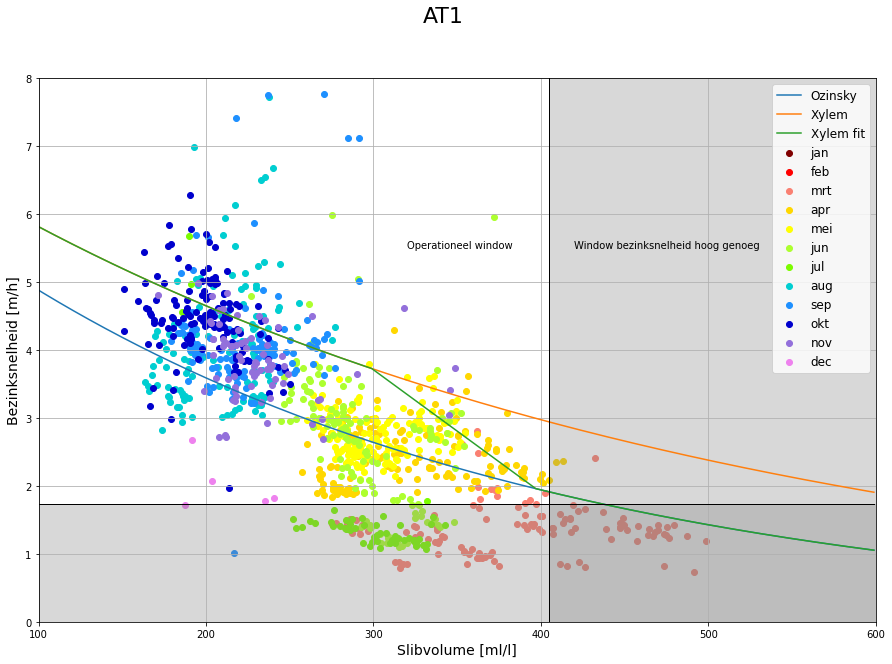

In [77]:
import matplotlib.pyplot as plt
colors = {1:'maroon', 2:'red', 3: 'salmon', 4:'gold', 5:'yellow', 6:'greenyellow', 7:'lawngreen', 8: 'darkturquoise', 9: 'dodgerblue', 10: 'mediumblue',11: 'mediumpurple', 12: 'violet'}
legend = {1:"jan",2:"feb",3:"mrt",4:"apr",5:"mei",6:"jun",7:"jul",8:"aug",9:"sep",10:"okt",11:"nov",12:"dec"}
df1_filter = df1_filter.assign(Month = df1_filter.index.month)


fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_xlim(100,600)
ax.set_ylim(0,8)
ax.set_xlabel("Slibvolume [ml/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
for i in range(12):
    ax.scatter(x=df1_filter[df1_filter["Month"]==i+1]["Slibvolume1"], y=df1_filter[df1_filter["Month"]==i+1]['Totale snelheid1'], color=colors[i+1], label = legend[i+1])

ax.plot(t, ozinsky(t, 120), label="Ozinsky")
ax.plot(t, xylem(t, 120), label="Xylem")
ax.plot(t, xylem_fit(t, 120), label="Xylem fit")
#ax.plot(t, p(np.log(t)), "b-", label = "Fit")
ax.plot(t, min_snelheid(t), color="black", linewidth=1)
plt.axvline(x=405, color="black", linewidth=1)

plt.axvspan(405,600, color="grey", alpha=0.3)
plt.axhspan(0,1.74, color="grey", alpha=0.3)
plt.text(320,5.5,"Operationeel window")
plt.text(420,5.5,"Window bezinksnelheid hoog genoeg")

plt.legend(fontsize="12")
plt.grid(which='major', axis='both')
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\AT1_Slibvolume_Bezinksnelheid")

In [78]:
# Logaritmische fit AT2
df2_nonan = df2_filter[df2_filter["Totale snelheid2"].notnull()]
x = np.array(df2_nonan["Slibvolume2"])
y = np.array(df2_nonan["Totale snelheid2"])
z = np.polyfit(np.log(x), y, 1.001)
p = np.poly1d(z)

LinAlgError: SVD did not converge in Linear Least Squares

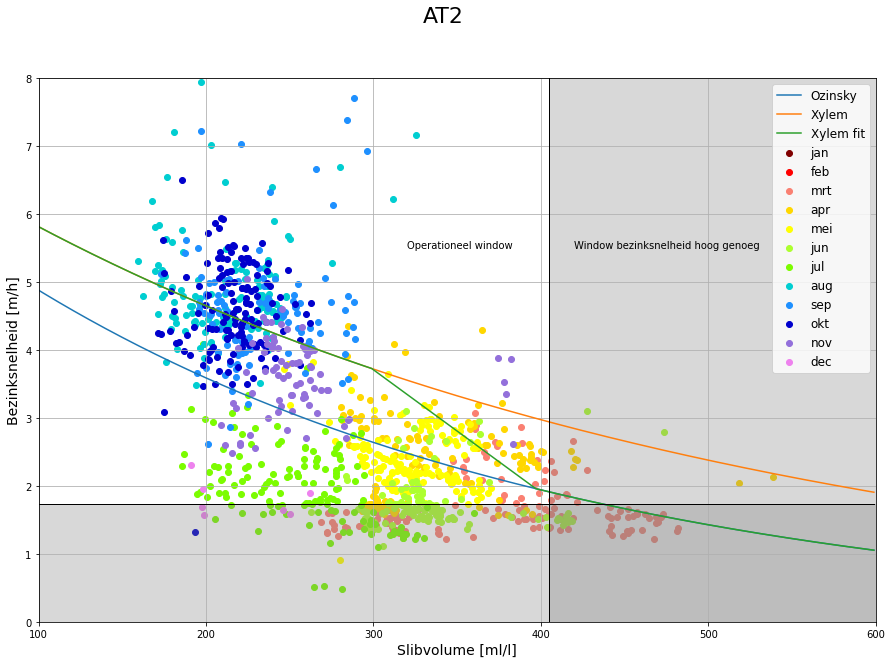

In [79]:
colors = {1:'maroon', 2:'red', 3: 'salmon', 4:'gold', 5:'yellow', 6:'greenyellow', 7:'lawngreen', 8: 'darkturquoise', 9: 'dodgerblue', 10: 'mediumblue',11: 'mediumpurple', 12: 'violet'}
legend = {1:"jan",2:"feb",3:"mrt",4:"apr",5:"mei",6:"jun",7:"jul",8:"aug",9:"sep",10:"okt",11:"nov",12:"dec"}
df2_filter = df2_filter.assign(Month = df2_filter.index.month)


fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_xlim(100,600)
ax.set_ylim(0,8)
ax.set_xlabel("Slibvolume [ml/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
for i in range(12):
    ax.scatter(x=df2_filter[df2_filter["Month"]==i+1]["Slibvolume2"], y=df2_filter[df2_filter["Month"]==i+1]['Totale snelheid2'], color=colors[i+1], label = legend[i+1])

ax.plot(t, ozinsky(t, 120), label="Ozinsky")
ax.plot(t, xylem(t, 120), label="Xylem")
ax.plot(t, xylem_fit(t, 120), label="Xylem fit")
#ax.plot(t, p(np.log(t)), "b-", label = "Fit")
ax.plot(t, min_snelheid(t), color="black", linewidth=1)
plt.axvline(x=405, color="black", linewidth=1)

plt.axvspan(405,600, color="grey", alpha=0.3)
plt.axhspan(0,1.74, color="grey", alpha=0.3)
plt.text(320,5.5,"Operationeel window")
plt.text(420,5.5,"Window bezinksnelheid hoog genoeg")

plt.legend(fontsize="12")
plt.grid(which='major', axis='both')
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\AT2_Slibvolume_Bezinksnelheid")

In [ ]:
at1 = "mediumpurple"
at2 = "darkturq"
dwa = "red"
rwa = "dodgerblue"

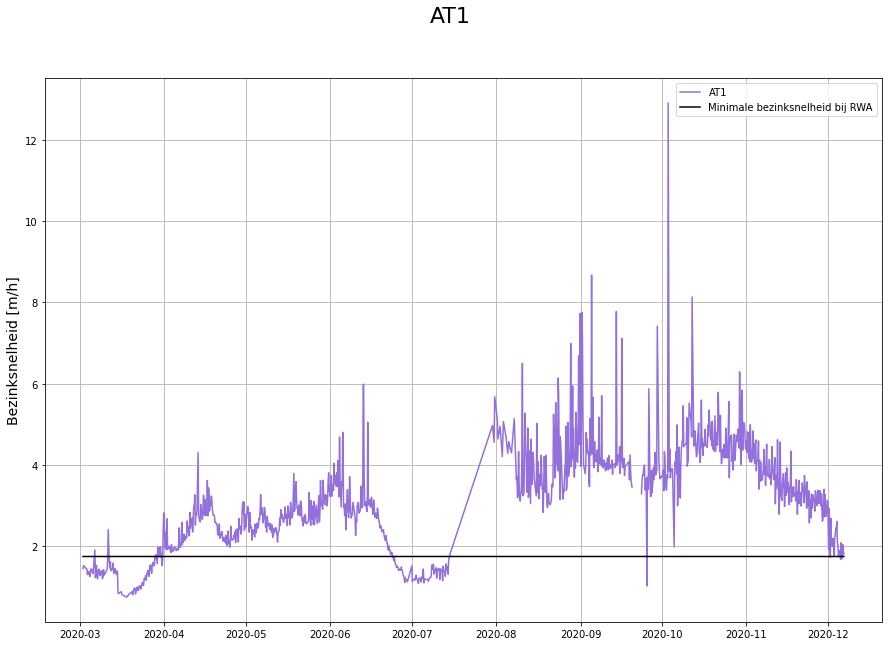

In [163]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(df1_filter.index, df1_filter["Totale snelheid1"], color=at1, label="AT1")
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend()
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\AT1_Bezinksnelheid")

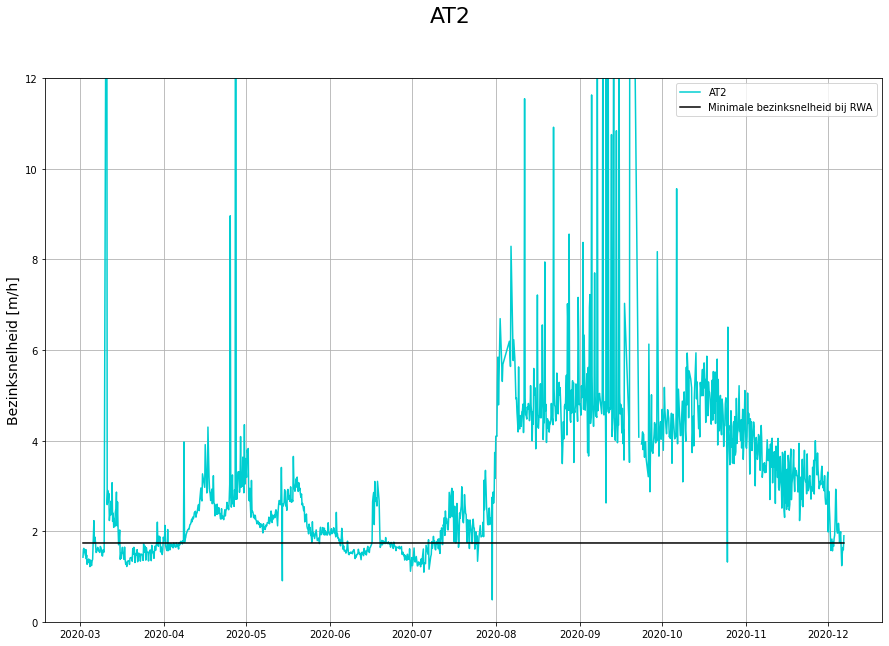

In [218]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
plt.plot(df2_filter.index, df2_filter["Totale snelheid2"], color = at2, label="AT2")
ax.plot(df2_filter.index, min_snelheid(df2_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend()
ax.set_ylim(0,12)
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\AT2_Bezinksnelheid")

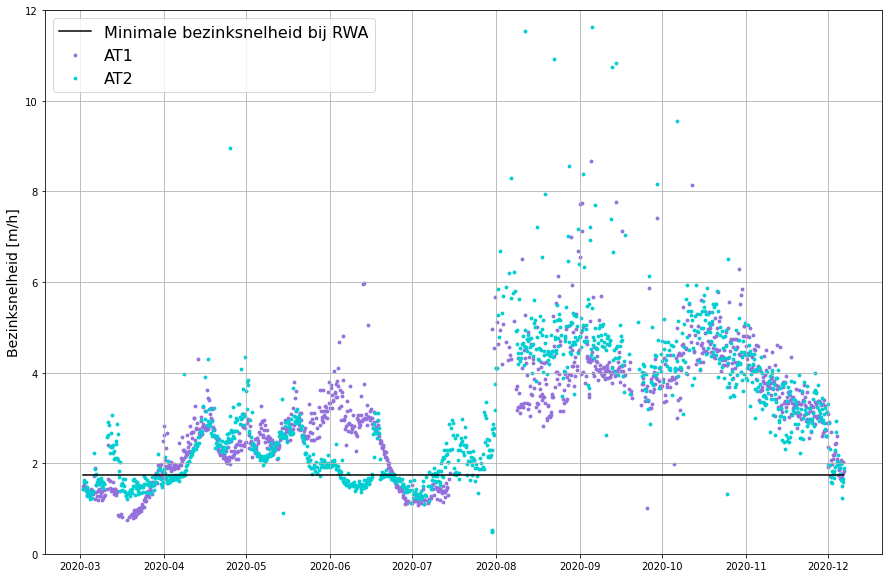

In [165]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_filter.index, df1_filter["Totale snelheid1"], label = "AT1",s=8, color=at1)
plt.scatter(df2_filter.index, df2_filter["Totale snelheid2"], label = "AT2", s=8, color=at2)
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend(fontsize="16")
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\Bezinksnelheid")

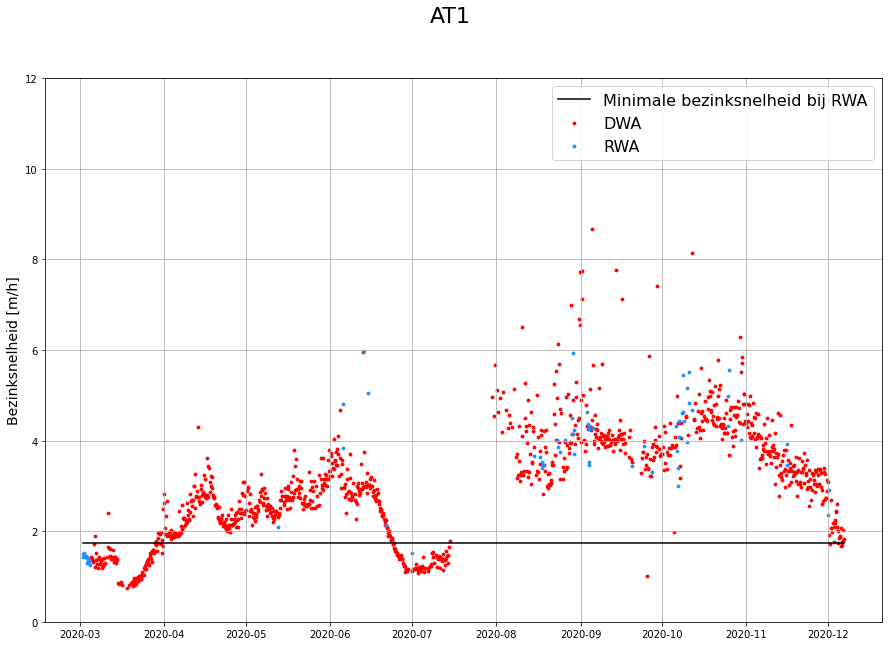

In [166]:
# DWA versus RWA
cut = datetime.timedelta(hours=4)
df1_DWA = df1_filter[df1_filter["Cyclusduur1"] > cut]
df1_RWA = df1_filter[df1_filter["Cyclusduur1"] < cut]

fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
fig.suptitle("AT1",fontsize=22)
ax.set_ylim(0,12)
plt.scatter(df1_DWA.index, df1_DWA["Totale snelheid1"], label = "DWA",s=8,  color=dwa)
plt.scatter(df1_RWA.index, df1_RWA["Totale snelheid1"], label = "RWA", s=8, color=rwa)
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend(fontsize="16")
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\Cyclusduur_Bezinksnelheid_AT1")

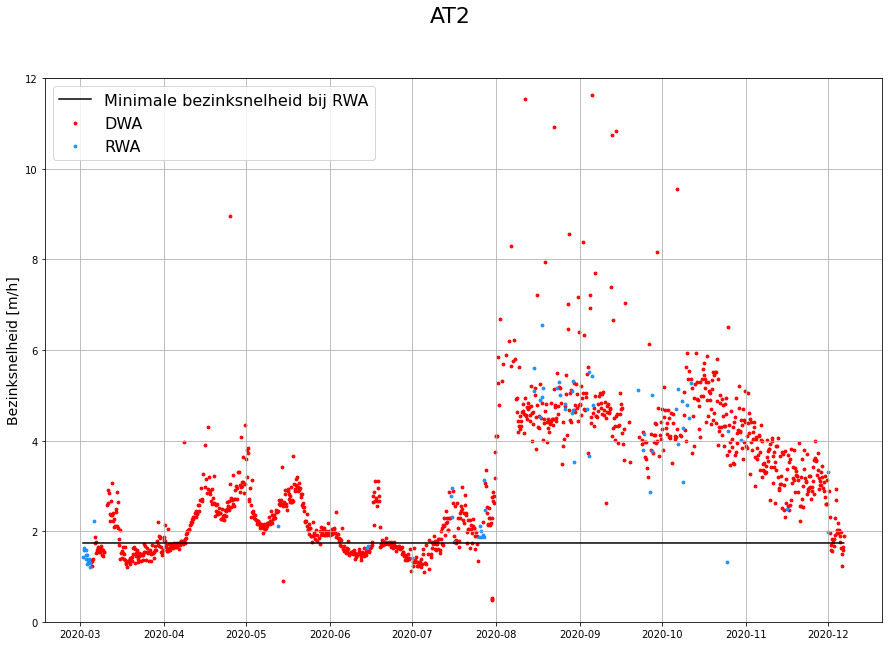

In [167]:
# DWA versus RWA
cut = datetime.timedelta(hours=4)
df2_DWA = df2_filter[df2_filter["Cyclusduur2"] > cut]
df2_RWA = df2_filter[df2_filter["Cyclusduur2"] < cut]

fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df2_DWA.index, df2_DWA["Totale snelheid2"], label = "DWA",s=8, color=dwa)
plt.scatter(df2_RWA.index, df2_RWA["Totale snelheid2"], label = "RWA", s=8, color=rwa)
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\Cyclusduur_Bezinksnelheid_AT2")

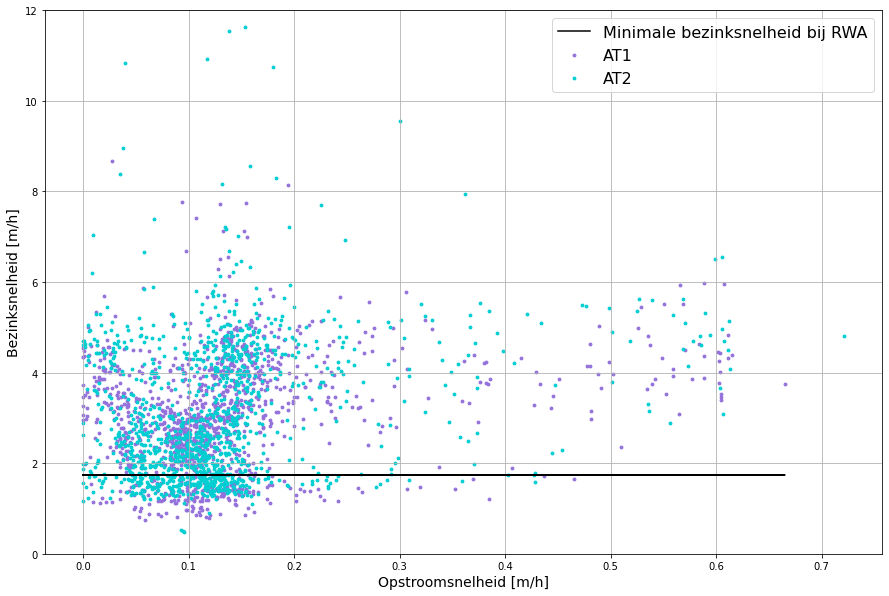

In [168]:
# DWA versus RWA
cut = datetime.timedelta(hours=4)

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Opstroomsnelheid [m/h]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_filter["Opstroomsnelheid1"], df1_filter["Totale snelheid1"], label = "AT1",s=8, color=at1)
plt.scatter(df2_filter["Opstroomsnelheid2"], df2_filter["Totale snelheid2"], label = "AT2", s=8, color=at2)
ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\Opstroomsnelheid_Bezinksnelheid")

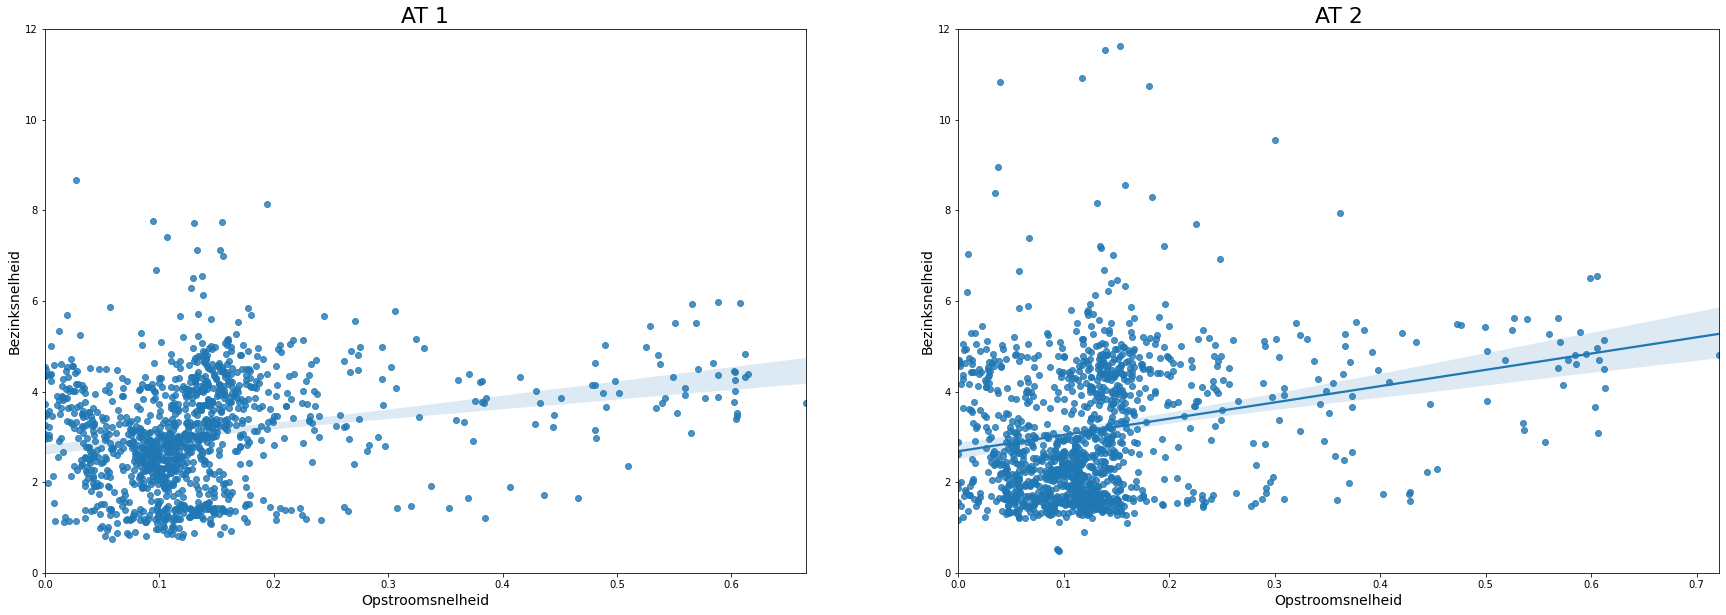

In [215]:
import seaborn as sns
fix, axs = plt.subplots(ncols=2, figsize=(30,10))
sns.regplot(df1_filter["Opstroomsnelheid1"], df1_filter["Totale snelheid1"], ax=axs[0])
axs[0].set_ylim(0,12)
axs[0].set_title("AT 1", fontsize=22)
axs[0].set_xlabel("Opstroomsnelheid", fontsize=14)
axs[0].set_ylabel("Bezinksnelheid", fontsize=14)
seaborn.regplot(df2_filter["Opstroomsnelheid2"], df2_filter["Totale snelheid2"], ax=axs[1])
axs[1].set_ylim(0,12)
axs[1].set_title("AT 2", fontsize=22)
axs[1].set_xlabel("Opstroomsnelheid", fontsize=14)
axs[1].set_ylabel("Bezinksnelheid", fontsize=14)
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\Regressie_Opstroomsnelheid_Bezinksnelheid")


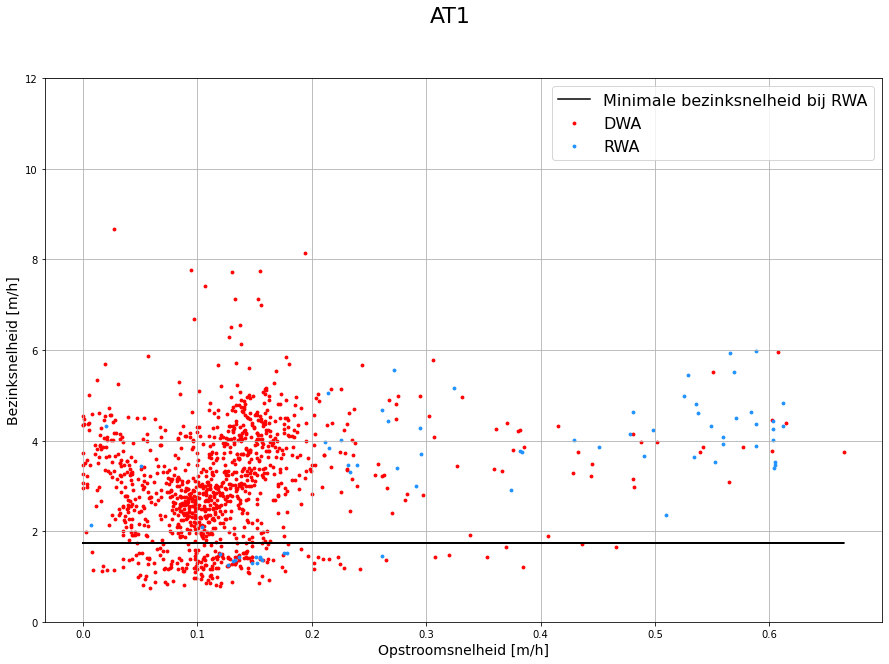

In [169]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_xlabel("Opstroomsnelheid [m/h]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_DWA["Opstroomsnelheid1"], df1_DWA["Totale snelheid1"], label = "DWA",s=8, color=dwa)
plt.scatter(df1_RWA["Opstroomsnelheid1"], df1_RWA["Totale snelheid1"], label = "RWA", s=8, color=rwa)
ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\Cyclusduur_Opstroomsnelheid_Bezinksnelheid_AT1")

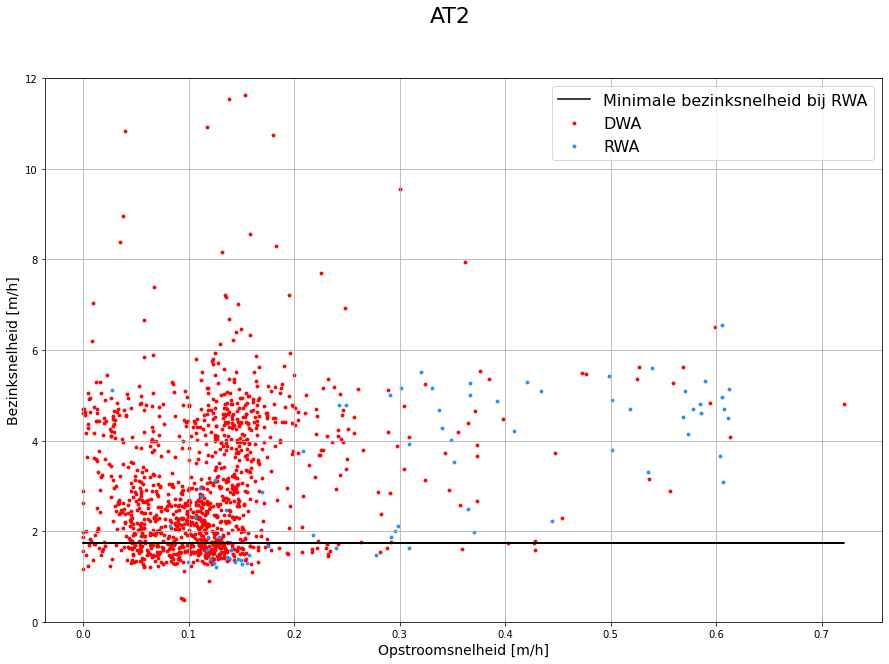

In [170]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_xlabel("Opstroomsnelheid [m/h]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df2_DWA["Opstroomsnelheid2"], df2_DWA["Totale snelheid2"], label = "DWA",s=8, color=dwa)
plt.scatter(df2_RWA["Opstroomsnelheid2"], df2_RWA["Totale snelheid2"], label = "RWA", s=8, color=rwa)
ax.plot(df2_filter["Opstroomsnelheid2"], min_snelheid(df2_filter["Opstroomsnelheid2"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\Cyclusduur_Opstroomsnelheid_Bezinksnelheid_AT2")